# Layer Fusion

Layer fusion related computations are listed in this notebook.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import OrderedDict
from functools import reduce

## Convolution Block

In [16]:
class ConvLayer:
    def __init__(self, name, H, W, C, F, K, T):
        self.name = name
        self.H = H
        self.W = W
        self.C = C
        self.F = F
        self.K = K
        self.T = T # type
        
    def __str__(self):
        return "%10s: <%4d, %4d, %4d, %4d, %4d, %10s>" % (self.name, self.H, self.W, self.C, self.F, self.K, self.T)
    
    def __repr__(self):
        return self.__str__()

In [17]:
def create_depthwise_separable_block(H, W, C, F, K):
    return [
        ConvLayer("conv1", H, W, C, C, K, "depthwise"),
        ConvLayer("conv2", H, W, C, F, 1, "pointwise")
    ]
def create_bottleneck_block(H, W, C, F, K):
    return [
        ConvLayer("conv1", H, W, C, F, 1, "pointwise"),
        ConvLayer("conv2", H, W, F, F, K, "standard"),
        ConvLayer("conv3", H, W, F, C, 1, "pointwise")
    ]
def create_separable_bottleneck_block(H, W, C, F, K):
    return [
        ConvLayer("conv1", H, W, C, F, 1, "pointwise"),
        ConvLayer("conv2", H, W, F, F, K, "depthwise"),
        ConvLayer("conv3", H, W, F, C, 1, "pointwise")
    ]

In [18]:
create_depthwise_separable_block(56, 56, 256, 256, 3)

[     conv1: <  56,   56,  256,  256,    3,  depthwise>,
      conv2: <  56,   56,  256,  256,    1,  pointwise>]

In [19]:
create_bottleneck_block(56, 56, 256, 256, 3)

[     conv1: <  56,   56,  256,  256,    1,  pointwise>,
      conv2: <  56,   56,  256,  256,    3,   standard>,
      conv3: <  56,   56,  256,  256,    1,  pointwise>]

In [20]:
create_separable_bottleneck_block(56, 56, 256, 256, 3)

[     conv1: <  56,   56,  256,  256,    1,  pointwise>,
      conv2: <  56,   56,  256,  256,    3,  depthwise>,
      conv3: <  56,   56,  256,  256,    1,  pointwise>]

## Baseline Result

In [39]:
class BaselineModel:
    def get_cycles(self, block, params, seqs):
        num_cycles = 0
        for layer in block:
            param = params[layer.name]
            if layer.T == "standard" or layer.T == "pointwise":
                num_cycles += layer.H * layer.W * layer.C * layer.F / (param["P_W"] * param["P_C"] * param["P_F"])
            elif layer.T == "depthwise":
                num_cycles += layer.H * layer.W * layer.C / (param["P_W"] * param["P_C"])
        return num_cycles

    def get_resources(self, block, params, seqs):
        num_mults = 0
        for layer in block:
            param = params[layer.name]
            if layer.T == "standard":
                num_mults += param["P_W"] * param["P_C"] * param["P_F"] * (layer.K ** 2)
            elif layer.T == "depthwise":
                num_mults += param["P_W"] * param["P_C"] * (layer.K ** 2)
            elif layer.T == "pointwise":
                num_mults += param["P_W"] * param["P_C"] * param["P_F"]
        return num_mults

In [40]:
model = BaselineModel()
model.get_cycles(
    create_depthwise_separable_block(56, 56, 256, 256, 3),
    {"conv1": {"P_W": 1, "P_C": 1}, "conv2": {"P_W": 1, "P_C": 1, "P_F": 1}},
    None)

206323712.0

In [41]:
model.get_cycles(
    create_bottleneck_block(56, 56, 256, 256, 3),
    {"conv1": {"P_W": 1, "P_C": 1, "P_F": 1},
     "conv2": {"P_W": 1, "P_C": 1, "P_F": 1},
     "conv3": {"P_W": 1, "P_C": 1, "P_F": 1}},
    None)

616562688.0

In [42]:
model.get_cycles(
    create_separable_bottleneck_block(56, 56, 256, 256, 3),
    {"conv1": {"P_W": 1, "P_C": 1, "P_F": 1},
     "conv2": {"P_W": 1, "P_C": 1, "P_F": 1},
     "conv3": {"P_W": 1, "P_C": 1, "P_F": 1}},
    None)

411844608.0

In [51]:
def factors(n):
    return [i for i in range(1, n+1) if n % i == 0]

def to_params(block, prod):
    idx = 0
    params = OrderedDict()
    for layer in block:
        if layer.T == "depthwise":
            params[layer.name] = {"P_W": prod[idx], "P_C": prod[idx+1]}
            idx += 2
        elif layer.T == "pointwise" or layer.T == "standard":
            params[layer.name] = {"P_W": prod[idx], "P_C": prod[idx+1], "P_F": prod[idx+2]}
            idx += 3
    return params

def validate(block, params):
    is_P_W_valid = reduce(lambda x, y: x and params[y.name]["P_W"] == params[block[0].name]["P_W"],
                          block)
    is_P_C_F_valid = True
    for idx, layer in enumerate(block):
        if idx > 0 and params[layer.name]["P_C"] != params[block[idx-1].name]["P_C"]:
            is_P_C_F_valid = False
            break
    
    return is_P_W_valid and is_P_C_F_valid
    

def resolve_block(block, max_mults):
    model = BaselineModel()
    block_param_cand = []
    for layer in block:
        if layer.T == "depthwise":
            block_param_cand.extend([[1, 2], factors(layer.C)])
        elif layer.T == "pointwise" or layer.T == "standard":
            block_param_cand.extend([[1, 2], factors(layer.C), factors(layer.F)])

    results = []
    products = list(itertools.product(*block_param_cand))
    for idx, prod in enumerate(products):
        params = to_params(block, prod)
        # all P_W should equal
        if not validate(block, params):
            continue
        num_mults = model.get_resources(block, params, None)
        if num_mults >= max_mults:
            continue
        num_cycles = model.get_cycles(block, params, None)
        results.append([num_cycles, num_mults, params, None])
    
    return results

In [55]:
results = [
    resolve_block(create_depthwise_separable_block(56, 56, 256, 256, 3), 1963),
    resolve_block(create_bottleneck_block(56, 56, 256, 256, 3), 1963),
    resolve_block(create_separable_bottleneck_block(56, 56, 256, 256, 3), 1963)
]

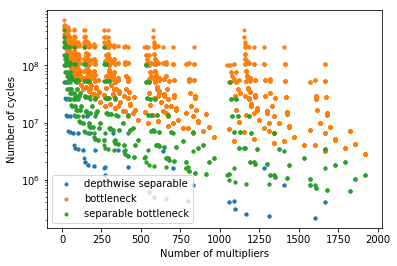

In [57]:
xss = []
yss = []
for result in results:
    xss.append([x[1] for x in result])
    yss.append([x[0] for x in result])
    
plt.scatter(xss[0], yss[0], marker='.', label='depthwise separable')
plt.scatter(xss[1], yss[1], marker='.', label='bottleneck')
plt.scatter(xss[2], yss[2], marker='.', label='separable bottleneck')

plt.xlabel('Number of multipliers')
plt.ylabel('Number of cycles')
plt.yscale('log')
plt.legend()